### Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split ## 訓練、測試切割
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_percentage_error,mean_squared_error
from sklearn.model_selection import cross_val_score

### Data Preprocessing

In [2]:
house_data = pd.read_csv("HousingData.csv", header= None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
house_data = house_data.drop(0,axis=0)
#刪除重複的值
print("原始比數：",house_data.shape)
house_data.drop_duplicates(inplace=True)
house_data = house_data.sort_index(axis=0)
print("刪除重複的值後：",house_data.shape)

# 判斷是否還有空值
house_data.isnull().sum(axis=0)

原始比數： (506, 14)
刪除重複的值後： (506, 14)


CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [3]:
#將把'LSTAT'中無法轉換為數字的值設為 NaN
house_data['CRIM'] = pd.to_numeric(house_data['CRIM'], errors='coerce')
house_data['ZN'] = pd.to_numeric(house_data['ZN'], errors='coerce')
house_data['INDUS'] = pd.to_numeric(house_data['INDUS'], errors='coerce')
house_data['CHAS'] = pd.to_numeric(house_data['CHAS'], errors='coerce')
house_data['AGE'] = pd.to_numeric(house_data['AGE'], errors='coerce')
house_data['LSTAT'] = pd.to_numeric(house_data['LSTAT'], errors='coerce')

#刪除問號的值(取平均數)
house_data['CRIM'].fillna(house_data['CRIM'].mean(), inplace=True)
house_data['ZN'].fillna(house_data['ZN'].mean(), inplace=True)
house_data['INDUS'].fillna(house_data['INDUS'].mean(), inplace=True)
house_data['CHAS'].fillna(house_data['CHAS'].mean(), inplace=True)
house_data['AGE'].fillna(house_data['AGE'].mean(), inplace=True)
house_data['LSTAT'].fillna(house_data['LSTAT'].mean(), inplace=True)

In [4]:
house_data.isnull().sum(axis=0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [5]:
## 數值屬性做Normalization(z-score)
numerical_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
scaler = preprocessing.StandardScaler()
house_data[numerical_columns] = scaler.fit_transform(house_data[numerical_columns])
house_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,-0.422328,0.296443,-1.311010,-0.279851,-0.144217,0.413672,-1.210593e-01,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.104146,24
2,-0.419870,-0.489639,-0.599771,-0.279851,-0.740262,0.194274,3.787156e-01,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.510353,21.6
3,-0.419872,-0.489639,-0.599771,-0.279851,-0.740262,1.282714,-2.706270e-01,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.239748,34.7
4,-0.419277,-0.489639,-1.330435,-0.279851,-0.835284,1.016303,-8.287698e-01,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.395333,33.4
5,-0.414981,-0.489639,-1.330435,-0.279851,-0.835284,1.228577,-5.223385e-01,1.077737,-0.752922,-1.106115,0.113032,0.441052,0.000000,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,-0.415733,-0.489639,0.126411,-0.279851,0.158124,0.439316,2.121240e-02,-0.625796,-0.982843,-0.803212,1.176466,0.387217,0.000000,22.4
503,-0.417766,-0.489639,0.126411,-0.279851,0.158124,-0.234548,2.984598e-01,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.518917,20.6
504,-0.415952,-0.489639,0.126411,-0.279851,0.158124,0.984960,8.201227e-01,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-1.009938,23.9
505,-0.410232,-0.489639,0.126411,-0.279851,0.158124,0.725672,7.581068e-01,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.890038,22


### Dataset Splitting

In [30]:
import xgboost as xgb
house_process=[]
for i in house_data["MEDV"].ravel():
    house_process.append(float(i))
house_data["MEDV"]=house_process

X = house_data.drop("MEDV",axis=1)
y = house_data["MEDV"]
## 7:3(215) / 8:2(6984)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=216)

k_scores=[]
train_performance=[]
test_performance=[]
for k in range(1,21):
    ## max_depth、eta、gamma
    # xgbrModel=xgb.XGBRegressor(booster='gblinear',verbosity=1)
    xgbrModel=xgb.XGBRegressor(booster='gbtree',max_depth=k,eta=0.2,gamma=10)
    xgbrModel.fit(X_train,y_train)
    pred=xgbrModel.predict(X_train)
    train_performance.append(np.sqrt(mean_squared_error(y_train,pred)))
    scores = cross_val_score(xgbrModel,X_train,y_train,cv=5,scoring=None,n_jobs=4,verbose=0)
    print(scores)
    print(scores.mean())
    k_scores.append(scores.mean())
    print(f'-------------------------------------------')

    ## 預測
    y_pred=xgbrModel.predict(X_test)
    #calculate rmse
    error_rmse = np.sqrt(mean_squared_error(y_test,y_pred)) 
    print('RMSE:', round(error_rmse,3))
    #calculate mape
    error_mape = mean_absolute_percentage_error(y_test,y_pred) 
    print(f'MAPE:{round((error_mape*100),2)}%')
    #calculate r squared
    error_r2 = r2_score(y_test,y_pred) 
    print('r_squared_value:', round(error_r2,3))
    test_performance.append(np.sqrt(mean_squared_error(y_test,y_pred)))

[0.72004408 0.67897105 0.88719646 0.73120081 0.78535976]
0.7605544324793103
-------------------------------------------
RMSE: 3.406
MAPE:11.41%
r_squared_value: 0.879
[0.71963509 0.71638517 0.91269052 0.73273634 0.82293284]
0.7808759929501619
-------------------------------------------
RMSE: 3.024
MAPE:10.45%
r_squared_value: 0.904
[0.67956255 0.67703302 0.90614442 0.70131945 0.8390993 ]
0.7606317481250587
-------------------------------------------
RMSE: 2.942
MAPE:9.97%
r_squared_value: 0.91
[0.66962171 0.70255689 0.90224958 0.72468206 0.76643595]
0.7531092379152433
-------------------------------------------
RMSE: 2.783
MAPE:9.56%
r_squared_value: 0.919
[0.65938149 0.66932103 0.8776077  0.74480093 0.76263456]
0.7427491406191586
-------------------------------------------
RMSE: 2.725
MAPE:9.56%
r_squared_value: 0.922
[0.63285776 0.64219585 0.85540257 0.74095045 0.74826107]
0.7239335402599137
-------------------------------------------
RMSE: 2.537
MAPE:9.18%
r_squared_value: 0.933
[0.

In [27]:
test_performance

[]

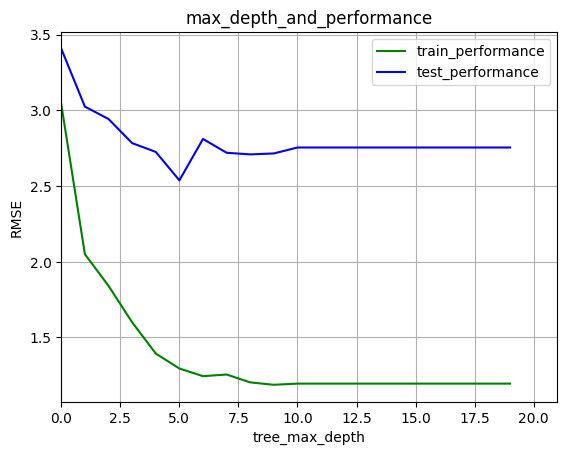

In [31]:
train = train_performance
test = test_performance
plt.plot(train, label='train_performance',color='green')
plt.plot(test, label='test_performance',color='blue')
plt.ylabel("RMSE")
plt.xlabel("tree_max_depth")
plt.title("max_depth_and_performance")
plt.xlim([0, 21])
plt.grid(True)
plt.legend()
plt.show()

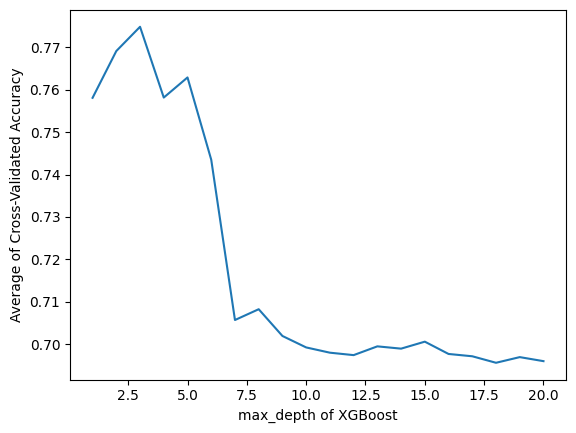

In [8]:
plt.plot(range(1,21),k_scores)
plt.xlabel('max_depth of XGBoost')
plt.ylabel('Average of Cross-Validated Accuracy')
plt.show()

In [9]:
xgbrModel.fit(X_train,y_train)
print(f'training_performance: {round(xgbrModel.score(X_train, y_train),3)}') 

training_performance: 1.0


In [9]:
import xgboost as xgb
house_process=[]
for i in house_data["MEDV"].ravel():
    house_process.append(float(i))
house_data["MEDV"]=house_process

X = house_data.drop("MEDV",axis=1)
y = house_data["MEDV"]
## 7:3(215) / 8:2(6984)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=216)

## max_depth、eta、gamma
# xgbrModel=xgb.XGBRegressor(booster='gblinear',verbosity=1)
xgbrModel=xgb.XGBRegressor(booster='gbtree',max_depth=2,eta=0.2)
xgbrModel.fit(X_train,y_train)
scores = cross_val_score(xgbrModel,X_train,y_train,cv=5,scoring=None,n_jobs=4,verbose=0)
print(scores)
print(scores.mean())


[0.72439937 0.72688614 0.92020572 0.74892288 0.82002787]
0.7880883963222027


### Evaluation

In [10]:
## 預測
y_pred=xgbrModel.predict(X_test)
#calculate rmse
error_rmse = np.sqrt(mean_squared_error(y_test,y_pred)) 
print('RMSE:', round(error_rmse,3))
#calculate mape
error_mape = mean_absolute_percentage_error(y_test,y_pred) 
print(f'MAPE:{round((error_mape*100),2)}%')
#calculate r squared
error_r2 = r2_score(y_test,y_pred) 
print('r_squared_value:', round(error_r2,3))

RMSE: 2.948
MAPE:10.5%
r_squared_value: 0.909


In [11]:
import xgboost as xgb
X = house_data.drop("MEDV",axis=1)
y = house_data["MEDV"]

score_max=[]
for i in range(200,10000):
    ## 7:3(215) / 8:2(6984)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=i)
    xgbrModel=xgb.XGBRegressor()
    xgbrModel.fit(X_train,y_train)
    print(f'training_accuracy: {round(xgbrModel.score(X_train, y_train),3)}') 

    ## 預測
    y_pred=xgbrModel.predict(X_test)
    #calculate rmse
    error_rmse = np.sqrt(mean_squared_error(y_test,y_pred)) 
    print('RMSE:', round(error_rmse,3))
    #calculate mape
    error_mape = mean_absolute_percentage_error(y_test,y_pred) 
    print('MAPE:', round(error_mape,3))
    #calculate r squared
    error_r2 = r2_score(y_test,y_pred) 
    print('r_squared_value:', round(error_r2,3))
    score_max.append(round(error_r2,3))
    print('--------------------------')
print(f'最佳的績效的random_state:{np.argmax(score_max)}')
print('==================================================')

training_accuracy: 1.0
RMSE: 4.361
MAPE: 0.127
r_squared_value: 0.826
--------------------------
training_accuracy: 1.0
RMSE: 3.328
MAPE: 0.132
r_squared_value: 0.85
--------------------------
training_accuracy: 1.0
RMSE: 3.503
MAPE: 0.119
r_squared_value: 0.873
--------------------------
training_accuracy: 1.0
RMSE: 3.813
MAPE: 0.117
r_squared_value: 0.823
--------------------------
training_accuracy: 1.0
RMSE: 3.782
MAPE: 0.11
r_squared_value: 0.813
--------------------------
training_accuracy: 1.0
RMSE: 2.974
MAPE: 0.105
r_squared_value: 0.87
--------------------------
training_accuracy: 1.0
RMSE: 4.569
MAPE: 0.13
r_squared_value: 0.746
--------------------------
training_accuracy: 1.0
RMSE: 3.184
MAPE: 0.121
r_squared_value: 0.862
--------------------------
training_accuracy: 1.0
RMSE: 3.402
MAPE: 0.118
r_squared_value: 0.873
--------------------------
training_accuracy: 1.0
RMSE: 3.464
MAPE: 0.113
r_squared_value: 0.871
--------------------------
training_accuracy: 1.0
RMSE: 3.668

: 

In [ ]:
import xgboost as xgb
for i in range(1,11,1):
   # 建立 XGBRegressor 模型
   xgbrModel=xgb.XGBRegressor(max_depth=i,random_state=0,verbosity=2)
   # 使用訓練資料訓練模型
   xgbrModel.fit(X_train,y_train)
   acc = xgbrModel.score(X_train.values, y_train)
   print(f'分類器準確度: {round(acc,3)}') 
   # 使用訓練資料                               
   pred=xgbrModel.predict(X_test)
   #calculate RMSE argument If True returns MSE value, if False returns RMSE value.
   #calculate rmse
   error_rmse = mean_squared_error(y_test,pred,squared=False) 
   print('RMSE value for max_depth= ' , i , 'is:', round(error_rmse,3))
   #calculate mape
   error_mape = mean_absolute_percentage_error(y_test,pred) 
   print('MAPE value for max_depth= ' , i , 'is:', round(error_mape,3))
   #calculate r squared
   error_r2 = r2_score(y_test,pred) 
   print('MAPE value for max_depth= ' , i , 'is:', round(error_r2,3))

In [ ]:
# plotting the y_test vs y_pred
plt.scatter(y_pred,Y_TEST)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
act_y =[round(i,1) for i in y_test.values]
pre_y =y_pred
plt.plot(pre_y, label='predict value',color='red')
plt.plot(act_y, label='true value',color='blue')
plt.ylabel("y")
plt.xlabel("X")
plt.title("predict of Y")
plt.xlim([0, 170])
plt.grid(True)
plt.legend()
plt.show()

In [24]:
xfeatures=list(X_train.columns[:])  
importances = list(xgbrModel.feature_importances_)
df_importance = pd.DataFrame({'feature':xfeatures,'feature_importance':importances})
df_importance = df_importance.sort_values(by=['feature_importance'],ascending=False).reset_index(drop=True)
print("每個特徵值的重要性：")
print(df_importance.loc[df_importance['feature_importance']!=0])

每個特徵值的重要性：
    feature  feature_importance
0     LSTAT            0.468041
1        RM            0.159025
2       DIS            0.135113
3      CRIM            0.037673
4   PTRATIO            0.035270
5       NOX            0.030429
6       RAD            0.026450
7        ZN            0.024358
8       TAX            0.023597
9         B            0.018795
10      AGE            0.014710
11    INDUS            0.013500
12     CHAS            0.013038


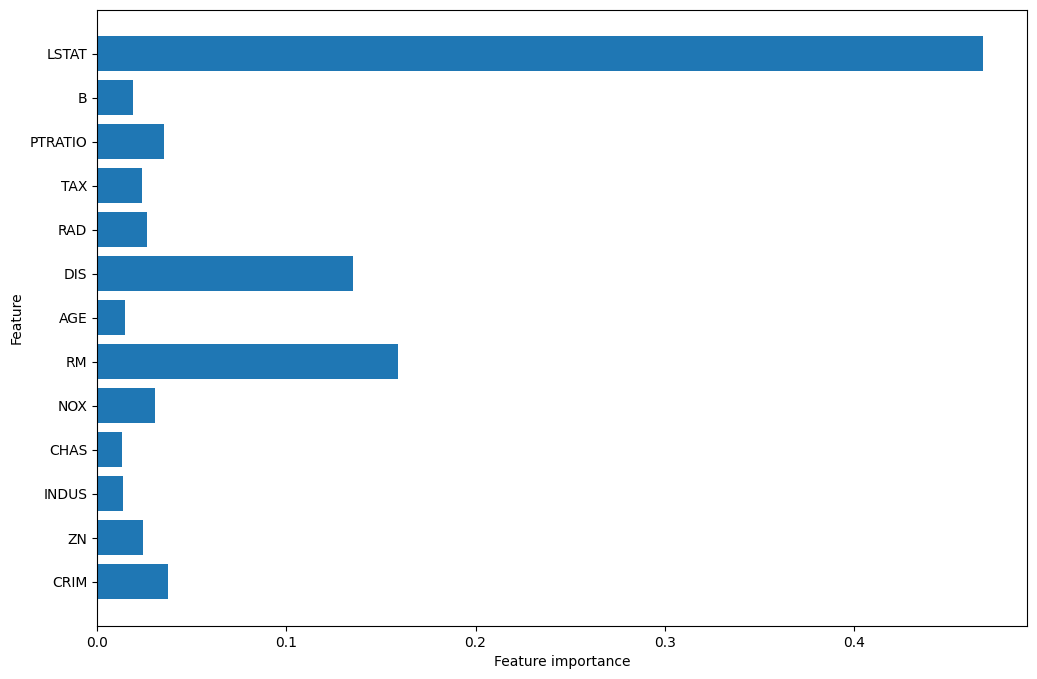

In [23]:
#以圖表事每個特徵變數的重要程度(0最小，1最大)
def plot_feature_importances_cancer(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,8))
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(xgbrModel)